# Model testing

- It's just a testing ground for the model. One model is loaded and a `cmc.test_model` is applied on it.
- As a result confusion matrix, ROC, AUROC, F1, PR curves will be generated and saved to the model's folder

In [1]:
import os
from pathlib import Path
import confinement_mode_classifier as cmc
import alt_models as am
import torchvision
import torch
from tqdm import tqdm
import torch.nn as nn
import re
import pandas as pd
path = Path(os.getcwd())
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
ris_option = 'RIS1'
second_img_opt = None
num_workers = 32
batch_size = 32
test_df_contains_val_df = True
exponential_elm_decay = False 
num_classes = 3
test_run = False
grayscale = False

In [3]:

#### Create dataloaders ########################################
shot_usage = pd.read_csv(f'{path}/data/shot_usageNEW.csv')
shot_for_ris = shot_usage[shot_usage['used_for_ris2'] if ris_option == 'RIS2' else shot_usage['used_for_ris1']]
shot_numbers = shot_for_ris['shot']
shots_for_testing = shot_for_ris[shot_for_ris['used_as'] == 'test']['shot']
shots_for_validation = shot_for_ris[shot_for_ris['used_as'] == 'val']['shot']
shots_for_training = shot_for_ris[shot_for_ris['used_as'] == 'train']['shot']

if test_run:
   shots_for_testing = shots_for_testing[:3]
   shots_for_validation = shots_for_validation[:3]
   shots_for_training = shots_for_training[:3]

if test_df_contains_val_df:
        shots_for_testing = pd.concat([shots_for_testing, shots_for_validation])

shot_df, test_df, val_df, train_df = cmc.load_and_split_dataframes(path,shot_numbers, shots_for_training, shots_for_testing, 
                                                               shots_for_validation, use_ELMS=num_classes==3, ris_option=ris_option,
                                                               exponential_elm_decay=exponential_elm_decay)

if ris_option == 'both':
   shot_for_ris2 = shot_usage[shot_usage['used_for_ris2']]
   shot_numbers_ris2 = shot_for_ris2['shot']
   shots_for_testing_ris2 = shot_for_ris2[shot_for_ris2['used_as'] == 'test']['shot']
   shots_for_validation_ris2 = shot_for_ris2[shot_for_ris2['used_as'] == 'val']['shot']
   shots_for_training_ris2 = shot_for_ris2[shot_for_ris2['used_as'] == 'train']['shot']

   if test_df_contains_val_df:
      shots_for_testing_ris2 = pd.concat([shots_for_testing_ris2, shots_for_validation_ris2])

   if test_run:
      shots_for_testing_ris2 = shots_for_testing_ris2[:3]
      shots_for_validation_ris2 = shots_for_validation_ris2[:3]
      shots_for_training_ris2 = shots_for_training_ris2[:3]

   shot_df_ris2, test_df_ris2, val_df_ris2, train_df_ris2 = cmc.load_and_split_dataframes(path,shot_numbers_ris2, shots_for_training_ris2, shots_for_testing_ris2, 
                                                                  shots_for_validation_ris2, use_ELMS=num_classes==3, ris_option='RIS2',
                                                                  exponential_elm_decay=exponential_elm_decay)

   test_df = pd.concat([test_df, test_df_ris2]).reset_index(drop=True)
   val_df = pd.concat([val_df, val_df_ris2]).reset_index(drop=True)
   train_df = pd.concat([train_df, train_df_ris2]).reset_index(drop=True)

   shots_for_testing = pd.concat([shots_for_testing, shots_for_testing_ris2]).reset_index(drop=True)
   shots_for_validation = pd.concat([shots_for_validation, shots_for_validation_ris2]).reset_index(drop=True)
   shots_for_training = pd.concat([shots_for_training, shots_for_training_ris2]).reset_index(drop=True)

test_dataloader = cmc.get_dloader(test_df, path, batch_size, balance_data=False, 
                                      shuffle=False, num_workers=num_workers, 
                                      augmentation=False, grayscale=grayscale)

In [4]:
len(shots_for_testing)

32

### Load the model

In [5]:
#Initiate a single camera model
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1', )
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_ftrs, 3) #3 classes: L-mode, H-mode, ELM
pretrained_model = pretrained_model.to(device)


if grayscale:
    # Luminance weights for RGB to grayscale conversion
    weights_rgb_to_gray = torch.tensor([0.2989, 0.5870, 0.1140]).view(1, 3, 1, 1).to(device)

    # Get the original weights of the first conv layer
    original_weights = pretrained_model.conv1.weight.data

    # Compute the weighted sum of the RGB channels
    grayscale_weights = (original_weights * weights_rgb_to_gray).sum(dim=1, keepdim=True)

    # Update the first convolutional layer
    pretrained_model.conv1 = nn.Conv2d(
        in_channels=1,
        out_channels=pretrained_model.conv1.out_channels,
        kernel_size=pretrained_model.conv1.kernel_size,
        stride=pretrained_model.conv1.stride,
        padding=pretrained_model.conv1.padding,
        bias=pretrained_model.conv1.bias is not None)

    # Assign the new grayscale weights to the first conv layer
    pretrained_model.conv1.weight = nn.Parameter(grayscale_weights)

    # If there is a bias term, keep it unchanged
    if pretrained_model.conv1.bias is not None:
        pretrained_model.conv1.bias = nn.Parameter(pretrained_model.conv1.bias.data)
        
#Which model to test?
model_path = f'{path}/runs/24-05-10, 19-50-51 both, NEW DATA, 3 classes, resnet34_all_layers'

#TEST one camera model
pretrained_model.load_state_dict(torch.load(f'{model_path}/model.pt'))
pretrained_model.eval()
pretrained_model.to(device)

#TEST ensembled model
# ensembled_model = cmc.TwoImagesModel(modelA=pretrained_model, modelB=pretrained_model, hidden_units=30).to(device)
# ensembled_model.load_state_dict(torch.load(f'{model_path}/model.pt'))
# ensembled_model.eval()
# ensembled_model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Test model on unbalanced test dset

In [6]:
test_dataloader.dataset.__len__()

64689

Processing batches:   0%|          | 0/2022 [00:00<?, ?it/s]

Processing batches: 100%|██████████| 2022/2022 [04:16<00:00,  7.88it/s]


Processing metrics...


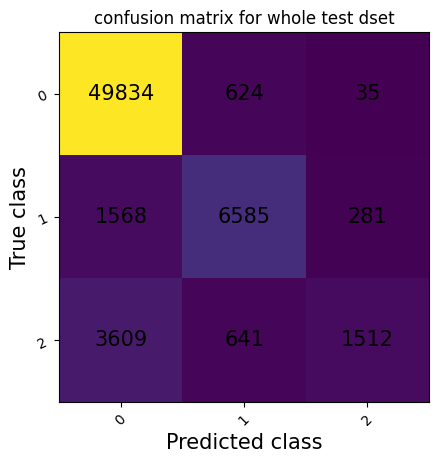

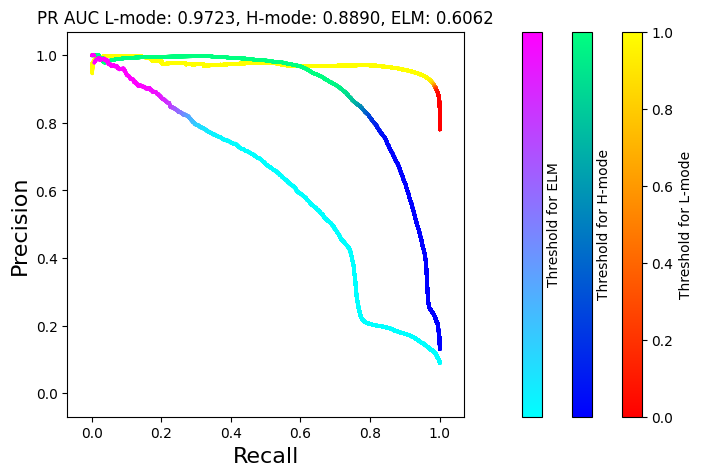

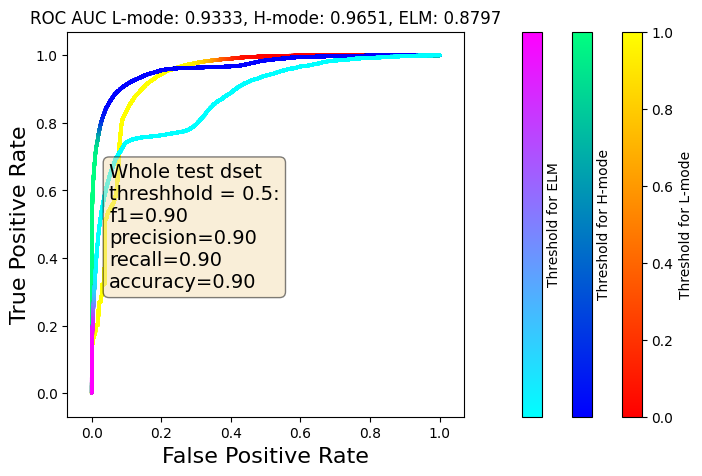

In [7]:
#metrics = cmc.test_model(f'{path}/RIS1 preds for doubtful shots', pretrained_model, test_dataloader_augmented, max_batch=0, comment='augmented_last_fc')
metrics = cmc.test_model(f'{path}/resnet34 both tested on ris1 only', pretrained_model, test_dataloader, 
                         max_batch=0, comment='original_last_fc', signal_name='img', num_classes=num_classes)

In [8]:
metrics['prediction_df'].to_csv(f'{path}/resnet34 both tested on ris1 only/prediction_df.csv')

In [9]:
shots_for_testing

2     16534
4     16773
8     17476
14    17483
15    17484
20    17837
28    18128
29    18130
31    18133
33    18248
38    18259
48    18274
50    18277
54    18359
69    19094
3     16769
9     17477
11    17479
16    17485
26    18057
30    18132
34    18250
35    18251
39    18260
40    18261
43    18267
47    18273
52    18347
55    18382
57    18433
58    18434
79    19379
Name: shot, dtype: int64

### Here the model is tested on individual shots (generates time-confidence graph)

In [10]:
img_path = cmc.per_shot_test(path=f'{path}/resnet34 both tested on ris1 only', 
                                shots=shots_for_testing, results_df=metrics['prediction_df'], 
                                writer=None, num_classes=num_classes, two_images=ris_option=='both')

  6%|▋         | 2/32 [00:00<00:04,  7.02it/s]/compass/Shared/Users/bogdanov/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 16%|█▌        | 5/32 [00:00<00:03,  7.23it/s]

 31%|███▏      | 10/32 [00:01<00:03,  6.84it/s]/compass/Shared/Users/bogdanov/.venv/lib/python3.8/site-packages/torchmetrics/utilities/plot.py:245: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(nrows=rows, ncols=cols) if ax is None else (ax.get_figure(), ax)
 44%|████▍     | 14/32 [00:02<00:02,  6.00it/s]/compass/Shared/Users/bogdanov/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 50%|█████     | 16/32 [00:02<00:02,  6.44it/s]/compass/Shared/Users/bogdanov/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid va

In [11]:
pd.DataFrame(img_path).to_csv(f'{path}/resnet34 both tested on ris1 only/metrics_per_shot.csv')

In [32]:
a = a[a['kappa']!=0]

In [33]:
a

,shot,f1,precision,recall,kappa
0,16534,0.961557,0.961557,0.961557,0.872749
1,16773,0.982692,0.982692,0.982692,0.916817
2,17476,1.000000,1.000000,1.000000,NaN
3,17483,0.999041,0.999041,0.999041,0.996251
4,17484,0.999522,0.999522,0.999522,0.997897
5,17837,0.875603,0.875603,0.875603,0.751450
6,18128,0.995387,0.995387,0.995387,0.986915
7,18130,0.998974,0.998974,0.998974,0.995533
8,18133,0.995900,0.995900,0.995900,0.941554
9,18248,0.842664,0.842664,0.842664,0.741320


In [34]:
#a = pd.DataFrame(img_path)
a['kappa'].describe()

count    28.000000
mean      0.701725
std       0.274566
min       0.072643
25%       0.479884
50%       0.780153
75%       0.932816
max       0.997897
Name: kappa, dtype: float64